In [1]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import open3d as o3d    
# import laspy

def PCA(data, correlation=False, sort=True):
    average_data = np.mean(data,axis=0)       # calulating the centroid
    decentration_matrix = data - average_data   # move the origin to the centroid
    H = np.dot(decentration_matrix.T,decentration_matrix)  # calculating decentration_matrix H
    eigenvectors,eigenvalues,eigenvectors_T = np.linalg.svd(H)    # SVD - eigenvalue,eigenvector


    if sort:
        sort = eigenvalues.argsort()[::-1]      # sorting as main component
        eigenvalues = eigenvalues[sort]         
        eigenvectors = eigenvectors[:, sort]

    return eigenvalues, eigenvectors

def collFeatures(pcd,length,size = 0.8):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)  #set a kd tree for tha point cloud, make searching faster
    normals = []
    llambda = []
    lp = []
    lo = []
    lc = []
    non_idx = []
    # print(point_cloud_o3d)  #geometry::PointCloud with 10000 points.
    print(length) #10000
    for i in range(length):
        # search_knn_vector_3d， input[point，x]      returns [int, open3d.utility.IntVector, open3d.utility.DoubleVector]
        [_, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[i], size)  
        # asarray is the same as array  but asarray will save the memeory
        k_nearest_point = np.asarray(pcd.points)[idx, :]  #find the surrounding points for each point, set them as a curve and use PCA to find the normal
        lamb, v = PCA(k_nearest_point)
        if len(k_nearest_point) == 1:
            non_idx.append(i)  # record the index that has no knn point
            p = 0
            o = 0
            c = 0
        else:
            p = (lamb[1]-lamb[2])/lamb[0] # calculate features based on eigenvalues
            o = pow(lamb[0]*lamb[1]*lamb[2],1.0/3.0)
            c = lamb[2]/sum(lamb)
        normals.append(v[:, 1])
        llambda.append(lamb)
        lp.append(p)
        lo.append(o)
        lc.append(c)
    return np.array(normals),np.array(llambda),np.array(lp).reshape(length,-1),np.array(lo).reshape(length,-1),np.array(lc).reshape(length,-1), np.array(non_idx)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data Load

In [2]:
######################### using pandas for point reading ################
lxyz = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959322/DEBY_LOD2_4959322.xyz', sep=" ", header=0)
lxyz.columns = ["x", "y", "z", "cla"]
print(lxyz.cla.value_counts())
print(len(lxyz))

lxyz_test = pd.read_csv('./data/test/labelledLocalCRS/DEBY_LOD2_4959459/DEBY_LOD2_4959459.xyz', sep=" ", header=0)
lxyz_test.columns = ["x", "y", "z", "cla"]
print(lxyz_test.cla.value_counts())
print(len(lxyz_test))

1     2869200
2      826645
5      746775
12     378061
16     366536
17     209118
3      111354
15      35457
11      22421
9        7342
13       1932
6        1319
14        731
Name: cla, dtype: int64
5576891
1     417280
2     276623
16    177257
5      93060
13     41630
17     24679
12     14055
3       4101
4       1072
9        682
Name: cla, dtype: int64
1050439


In [2]:
lxyz_1 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4906981/DEBY_LOD2_4906981.xyz', sep=" ", header=0)
lxyz_1.columns = ["x", "y", "z", "cla"]
lxyz_2 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959322/DEBY_LOD2_4959322.xyz', sep=" ", header=0)
lxyz_2.columns = ["x", "y", "z", "cla"]
lxyz_3 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959460/DEBY_LOD2_4959460.xyz', sep=" ", header=0)
lxyz_3.columns = ["x", "y", "z", "cla"]
lxyz_4 = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959462/DEBY_LOD2_4959462.xyz', sep=" ", header=0)
lxyz_4.columns = ["x", "y", "z", "cla"]
lxyz = pd.concat([lxyz_1, lxyz_2, lxyz_3, lxyz_4], axis = 0)
print(lxyz.cla.value_counts())
print(len(lxyz))

lxyz_test = pd.read_csv('./data/training/labelledLocalCRS/DEBY_LOD2_4959323/DEBY_LOD2_4959323.xyz', sep=" ", header=0)
lxyz_test.columns = ["x", "y", "z", "cla"]
print(lxyz_test.cla.value_counts())
print(len(lxyz_test))

1     36429131
16     7566216
11     7534665
5      7056168
2      6351914
12     5938935
15     3797046
17     3600867
7      1393392
3       691885
6       475590
10      419409
14      304608
8       220774
13       49393
9        29398
Name: cla, dtype: int64
81859391
1     19125652
5      6440977
2      3448050
12     1979855
16     1911652
17     1746219
6       628964
3       288073
14      242680
13       24642
Name: cla, dtype: int64


In [15]:
lxyz_train = pd.read_csv('./data/outputs/lxyz_train_xyzpocn.csv',index_col = False)
print(lxyz_train)

                x      y      z         p           o         c        n1  \
0        4.400000   5.60  11.00  0.889916  139.555687  0.034776  0.831919   
1        4.400000   5.65   9.80  0.862543  174.456555  0.040476 -0.937781   
2        4.400000   5.95   2.25  0.720397  376.340517  0.084192  0.758971   
3        4.400000   6.00   1.65  0.325332  283.398300  0.142658 -0.455799   
4        4.400000   5.80   2.90  0.760750  349.709760  0.078349  0.629671   
...           ...    ...    ...       ...         ...       ...       ...   
1241127  1.550000   6.95   7.25  0.265804  202.062927  0.112716  0.379005   
1241128  1.550000   7.00   7.60  0.432654  241.693884  0.088374 -0.496047   
1241129  1.550000   6.90   7.25  0.294161  214.719354  0.110785  0.317526   
1241130 -9.150001  11.45   7.10  0.322439   96.122849  0.084484 -0.711721   
1241131 -9.350000  11.30   5.30  0.403567  147.471003  0.076126  0.551258   

               n2        n3          l1          l2          l3  
0       -

In [16]:
lxyz_test = pd.read_csv('./data/outputs/lxyz_test_xyzpocn.csv',index_col = False)
print(lxyz_test)

            x          y          z         p          o         c        n1  \
0       14.25  12.950000   7.150000  0.117071   0.095071  0.023735  0.596763   
1       14.20  12.850000  19.150000  0.074767  17.740876  0.175874  0.938729   
2       14.20  12.800000  19.150000  0.080304  19.920146  0.159482  0.945373   
3       14.20  12.950000  19.200001  0.054315  12.568280  0.239675 -0.905330   
4       14.20  12.650001  19.600000  0.124446  25.038166  0.095084  0.944082   
...       ...        ...        ...       ...        ...       ...       ...   
627576 -13.80 -12.100000   1.600000  0.162190  40.424178  0.073496  0.882015   
627577 -13.80 -12.150001   1.600000  0.157458  46.817645  0.084224  0.860524   
627578 -13.80 -11.950000   1.550000  0.274379  15.954391  0.031064  0.954728   
627579 -13.85 -12.050000   1.600000  0.167637  29.673507  0.058562  0.896538   
627580 -13.85 -11.750000   1.600000  0.333941   5.438617  0.008600  0.999530   

              n2        n3          l1 

In [22]:
lclass_train = pd.read_csv("./data/outputs/lclass_train_xyzpocn.csv",index_col = False)
lclass_train = lclass_train.replace({14:1})
print(lclass_train.value_counts())

cla
0      504407
4      290500
1      190930
3      135591
5      105041
2       14663
dtype: int64


In [23]:
lclass_test = pd.read_csv("./data/outputs/lclass_test_xyzpocn.csv",index_col = False)
print(lclass_test.value_counts())

cla
0      229206
4      173727
1      152563
3       57049
5       12315
2        2721
dtype: int64


# Sample Points & Merge class

In [13]:
lclass = lxyz['cla'].replace({6:5,9:1,15:1,10:1,12:11,17:13,16:13})
print(lclass.value_counts())
lxyz = lxyz.drop('cla',axis = 1) #delete the column of class，the rest part can be viewed as the input 'features'
lxyz = lxyz.to_numpy().reshape(-1,3)
# lxyz = lxyz[0:300000]

lclass_test = lxyz_test['cla'].replace({6:5,9:1,15:1,10:1,12:11,17:13,16:13})
lxyz_test = lxyz_test.drop('cla',axis = 1)
# lxyz_test = lxyz_test[0:100000]
lxyz_test = lxyz_test.to_numpy().reshape(-1,3)

lclass = lclass.replace({5:4,13:5,11:6,14:2})
lclass_test = lclass_test.replace({5:4,13:5,11:6,14:2})

lclass = lclass.replace({1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7})
lclass_test = lclass_test.replace({1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7})
print(lclass.value_counts())
print(lclass_test.value_counts())
# 0: wall
# 1: window
# 2: door
# 3: molding
# 4: other
# 5: terrian
# 7: column
# 8: arch

1     2911999
2      826645
5      748094
13     577586
11     400482
3      111354
14        731
Name: cla, dtype: int64
0    2911999
1     827376
3     748094
4     577586
5     400482
2     111354
Name: cla, dtype: int64
0    417962
1    276623
4    243566
3     94132
5     14055
2      4101
Name: cla, dtype: int64


In [4]:
######################### using open3d for point processing ################
device = o3d.core.Device("CPU:0")
dtype = o3d.core.float32
pcd = o3d.t.geometry.PointCloud(device)
pcd.point.positions = o3d.core.Tensor(lxyz, dtype, device)
pcd.point.labels = o3d.core.Tensor(lclass.to_numpy().reshape(-1,1), o3d.core.int32, device)
# o3d.visualization.draw([pcd])
downpcd = pcd.voxel_down_sample(voxel_size = 0.05)

lxyz_train = downpcd.point.positions.numpy()
lclass_train = downpcd.point.labels.numpy()

pcd_test = o3d.t.geometry.PointCloud(device)
pcd_test.point.positions = o3d.core.Tensor(lxyz_test, dtype, device)
pcd_test.point.labels = o3d.core.Tensor(lclass_test.to_numpy().reshape(-1,1), o3d.core.int32, device)
# o3d.visualization.draw([pcd])
downpcd_test = pcd_test.voxel_down_sample(voxel_size = 0.05)

lxyz_test = downpcd_test.point.positions.numpy()
lclass_test = downpcd_test.point.labels.numpy()

# Add Features

In [5]:
print(lxyz_train)

[[-16.        -28.95        7.6      ]
 [-16.        -28.9         7.1      ]
 [-16.        -28.9         4.6      ]
 ...
 [  6.7000003  -2.25        0.25     ]
 [ -7.4        -2.3        17.       ]
 [ -7.5        -2.6000001  16.95     ]]


In [6]:
########## Normalization For Each Column ##########
def normalize_point_cloud(pcd):
    centroid = np.mean(pcd, axis=0) # calculation the center of point cloud
    pcd = pcd - centroid # put the center as origin
    m = np.max(np.sqrt(np.sum(pcd ** 2, axis=1))) # calculation the longest vector
    pcd_normalized = pcd / m # normalization to (-1, 1)
    return pcd_normalized


In [7]:
norm_lxyz_train = normalize_point_cloud(lxyz_train)
norm_lxyz_test = normalize_point_cloud(lxyz_test)

In [8]:
print(norm_lxyz_train)
print(norm_lxyz_test)

[[-0.19324374 -0.33067065 -0.01213908]
 [-0.19324374 -0.3298872  -0.01997327]
 [-0.19324374 -0.3298872  -0.05914425]
 ...
 [ 0.16242877  0.08767542 -0.12730175]
 [-0.05849557  0.08689201  0.13514382]
 [-0.06006241  0.08219149  0.1343604 ]]
[[-0.13739109 -0.55525166 -0.03275299]
 [-0.13739109 -0.5506215   0.07026852]
 [-0.13739109 -0.55525166  0.06679587]
 ...
 [ 0.17861868  0.33953062  0.07258359]
 [ 0.17746113  0.3383731   0.07142606]
 [ 0.17746113  0.33953062  0.07142606]]


In [9]:
pcd_train = o3d.geometry.PointCloud()
pcd_train.points = o3d.utility.Vector3dVector(norm_lxyz_train)

# show in color
# colors = plt.get_cmap("tab20")(np.array(lclass_train).reshape(-1) / 17.0)
# colors = colors[:,0:3]
# pcd_train.colors=o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw_geometries([pcd_train], window_name='test the color',width=800,height=600)

In [10]:
pcd_test = o3d.geometry.PointCloud()
pcd_test.points = o3d.utility.Vector3dVector(norm_lxyz_test)

# show in color
# colors = plt.get_cmap("tab20")(np.array(lclass_test).reshape(-1) / 17.0)
# colors = colors[:,0:3]
# pcd_test.colors=o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw_geometries([pcd_test], window_name='test the color',width=800,height=600)

In [11]:
normals,llambda,lp,lo,lc,non_index = collFeatures(pcd_train,downpcd.point.positions.shape[0])

14623737


KeyboardInterrupt: 

In [13]:
lxyz_train = np.hstack((lxyz_train,lp,lo,lc,normals,llambda))
lxyz_train = pd.DataFrame(lxyz_train)
lxyz_train.columns = ["x", "y", "z", "p","o","c","n1","n2","n3","l1","l2","l3"]
lxyz_train = lxyz_train.drop(lxyz_train.index[non_index])
lclass_train = np.delete(lclass_train, non_index, axis=0)  

In [16]:
lxyz_train = lxyz_train.reset_index()
lxyz_train = lxyz_train.drop('index',axis = 1)
lclass_train = pd.DataFrame(lclass_train, columns = ['cla'], dtype = int)

In [19]:
lxyz_train.to_csv("./data/outputs/lxyz_train_xyzpocn.csv",index=False)

In [2]:
lclass_train.to_csv("./data/outputs/lclass_train_xyzpocn.csv",index=False)

NameError: name 'lclass_train' is not defined

In [21]:
normals_t,llambda_t,lp_t,lo_t,lc_t,non_index_t = collFeatures(pcd_test,downpcd_test.point.positions.shape[0])
lxyz_test = np.hstack((lxyz_test,lp_t,lo_t,lc_t,normals_t,llambda_t))
lxyz_test = pd.DataFrame(lxyz_test)
lxyz_test.columns = ["x", "y", "z", "p","o","c","n1","n2","n3","l1","l2","l3"]
lxyz_test = lxyz_test.drop(lxyz_test.index[non_index_t])
lclass_test = np.delete(lclass_test, non_index_t, axis=0)

627590


In [22]:
lxyz_test = lxyz_test.reset_index()
lxyz_test = lxyz_test.drop('index',axis = 1)
lclass_test = pd.DataFrame(lclass_test, columns = ['cla'], dtype = int)

In [25]:
lxyz_test.to_csv("./data/outputs/lxyz_test_xyzpocn.csv",index=False)

In [26]:
lclass_test.to_csv("./data/outputs/lclass_test_xyzpocn.csv",index=False)

In [6]:
print(lxyz_train)

[[-16.        -28.95        7.6      ]
 [-16.        -28.9         7.1      ]
 [-16.        -28.9         4.6      ]
 ...
 [  6.7000003  -2.25        0.25     ]
 [ -7.4        -2.3        17.       ]
 [ -7.5        -2.6000001  16.95     ]]


In [7]:
print(lxyz_test)

[[  0.6      -22.5        7.15    ]
 [  0.6      -22.300001  11.6     ]
 [  0.6      -22.5       11.45    ]
 ...
 [ 14.25      16.15      11.7     ]
 [ 14.2       16.1       11.650001]
 [ 14.2       16.15      11.650001]]


In [8]:
print(lclass_train)

[[0]
 [0]
 [0]
 ...
 [4]
 [4]
 [4]]


In [9]:
print(lclass_test)

[[1]
 [1]
 [1]
 ...
 [4]
 [4]
 [4]]


In [10]:
print(len(lxyz_train))

14623737


# Classificatino based on RF

In [24]:
######################### Classification based on RF #######################
# divide the dataset into training and testing 
x_train = np.array(lxyz_train)
y_train = np.array(lclass_train)
x_test = np.array(lxyz_test)
y_test = np.array(lclass_test)

# x_train,x_test,y_train,y_test = train_test_split(lxyz,lclass[0:300000],test_size = 0.3,random_state=0)

print(x_train.shape) #check the amount of dataset
print(x_test.shape)

rfc = RandomForestClassifier() # using the default parameters for RF to train
rfc.fit(x_train,y_train) # model fitting

# way to score your result
score1 = rfc.score(x_test,y_test) #check the result that used in testing dataset
print(score1)

(1241132, 12)
(627581, 12)


C:\Users\15597\AppData\Local\Temp\ipykernel_2384\2699409989.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train) # model fitting


0.4970386292765396


In [25]:
importance = rfc.feature_importances_ # Check the importance of each feature
col = ["x", "y", "z", "p","o","c","n1","n2","n3","l1","l2","l3"]

re = pd.DataFrame({'Name of Feature':np.array(col),'importance':importance}).sort_values(by = 'importance',axis = 0,ascending = False)
print(re)

print("success!")

   Name of Feature  importance
2                z    0.269071
0                x    0.116130
1                y    0.110255
5                c    0.074546
10              l2    0.066507
9               l1    0.066240
3                p    0.061677
11              l3    0.055533
7               n2    0.053314
4                o    0.047254
6               n1    0.040151
8               n3    0.039322
success!


In [26]:
y_pred_rf = rfc.predict(x_test)

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
cm = confusion_matrix(y_test, y_pred_rf);
cm
correct_rate = np.diagonal(cm).sum()/cm.sum()
print(correct_rate)

0.4970386292765396


In [31]:
classes = {'wall & balcony & ..': 0,
           'window & blinds': 1,
           'door': 2,
           'molding & decoration': 3,
           'ground surface & terrian': 4,
           'roof & others': 5
           }
cla_test = {'wall & balcony & ..': 0,
           'window & blinds': 1,
           'door': 2,
           'molding & decoration': 3,
           'ground surface & terrian': 4,
           'roof & others': 5
           }
cla_test

{'wall & balcony & ..': 0,
 'window & blinds': 1,
 'door': 2,
 'molding & decoration': 3,
 'ground surface & terrian': 4,
 'roof & others': 5}

In [32]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


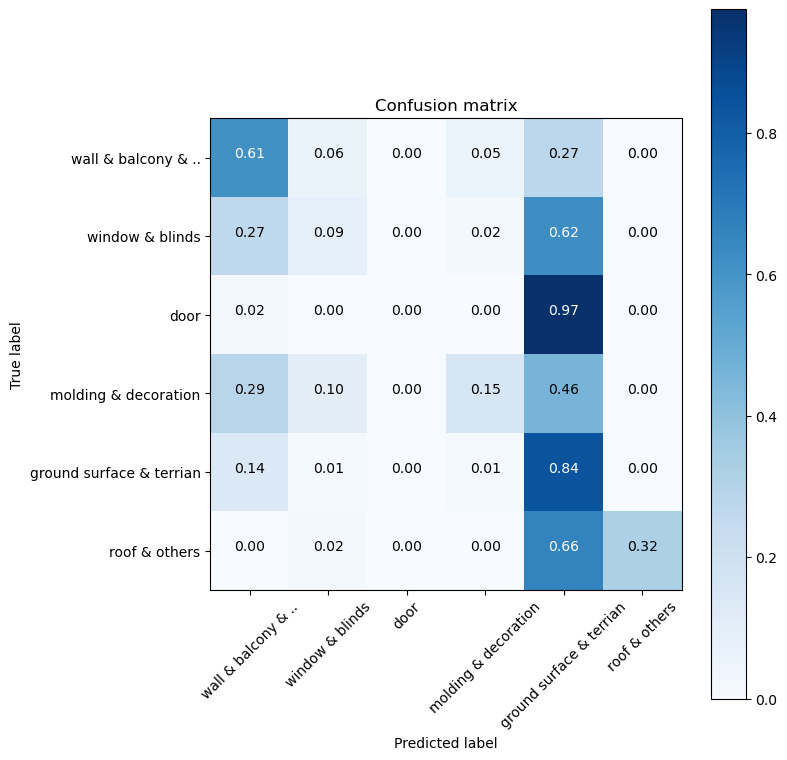

In [33]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(cla_test.keys()), normalize=True)

Confusion matrix, without normalization


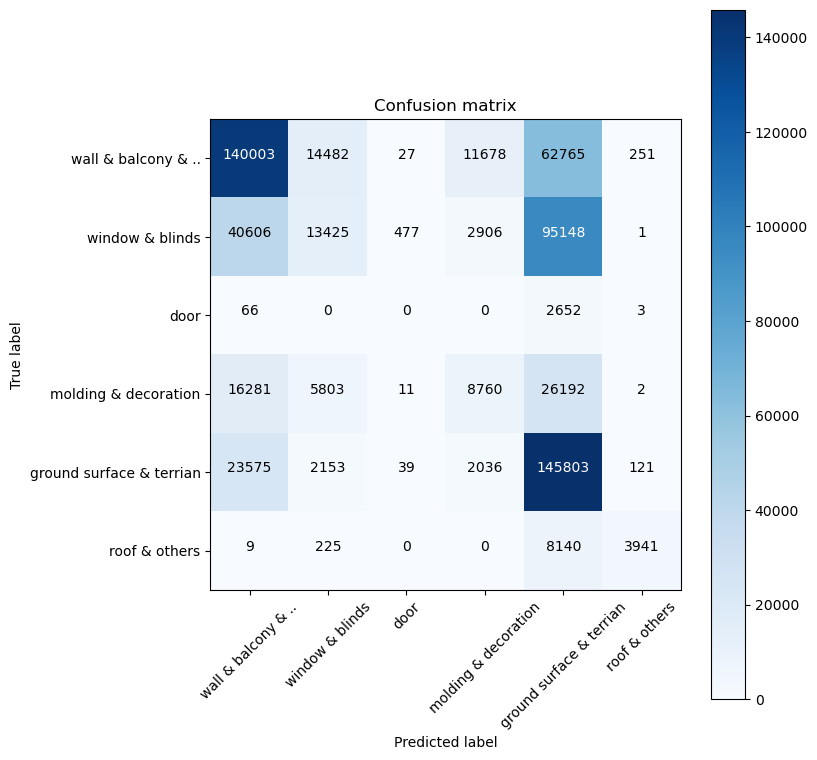

In [34]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(cla_test.keys()), normalize=False)

In [35]:
import joblib
joblib.dump(rfc, "rf_train_model_gf_sd.m")

['rf_train_model_gf_sd.m']